# Part 3 - Running the Model

While we tested our model in the previous notebook by having it play a large number of games, that doesn't give us a particularly good view of how it works, or why it's winning or losing games. So in this notebook we'll run through a game a Minesweeper step-by-step with our Pytorchsweeper AI, visualising both the game board and also the output of the neural network.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from game import MinesweeperGame
from IPython import display
from matplotlib import colors

To run the game, we create a function which iterates through a while loop, and uses `pyplot` to display the game state and network output at each step.

In [18]:
def run_game_with_visuals(model: torch.nn.Module, game: MinesweeperGame, device: str):
    finished = False
        
    while not finished:
        # Create two side-by-side plots, one for the game state and one for the output of the neural net.
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15), sharey=True)
        ax1.imshow(game.visible_gamestate)

        # Loop over data dimensions and create text annotations for all visible numbers and bombs.
        for i in range(game.visible_gamestate.shape[0]):
            for j in range(game.visible_gamestate.shape[1]):
                if game.visible_gamestate[i, j] > 0:
                    ax1.text(j, i, int(game.visible_gamestate[i, j]),
                             ha="center", va="center", color="w", size="xx-large")
                if game.is_over and game.minefield[i, j]:
                    ax1.text(j, i, "B",
                             ha="center", va="center", color="r", size="xx-large")

        # If the game has been won or lost, we update the title of the game state and end the loop.
        if game.won:
            ax1.set_title("Game won!")
            finished = True
        elif game.lost:
            ax1.set_title("Game lost!")
            finished = True
        else:
            ax1.set_title("Game state")

            # Here we're taking the game state data and converting it to a tensor for input to the network.
            input_array = np.array([game.visible_gamestate.astype('float32')/10.0])
            input_tensor = torch.from_numpy(input_array).to(device)

            # We run the model with the game state data to get our guess heatmap.
            with torch.no_grad():
                model_output = model(input_tensor)
            guess_heatmap = model_output.to('cpu').numpy()[0]

            # The output of the model is an array, with high numbers representing the squares that the
            # network is most confident are good guesses, and low numbers representing low confidence.
            # So, to get the X and Y coordinates of our guess, we choose the cell the network has
            # assigned the highest value to.
            best_x, best_y = np.unravel_index(np.argmax(guess_heatmap), guess_heatmap.shape)

        # Display the guess heatmap, and mark an X on the game state map showing the location of the guess.
        ax2.set_title("Guess heatmap")
        im2 = ax2.imshow(guess_heatmap, cmap='hot', norm=colors.NoNorm())
        ax1.text(best_y, best_x, "X",
                 ha="center", va="center", color="r", size="xx-large")

        plt.show()
        display.clear_output(wait=True)

        # Finally, make the guess, and wait half a second to continue the loop.
        game.guess(best_x, best_y)
        time.sleep(0.5)

In [19]:
device = "cpu"

We can load the model we saved in the previous notebook.

In [20]:
pytorchsweeper_model = torch.jit.load('pytorchsweeper_model.pt').to(device)

Then, we simply run our `run_game_with_visuals` function to see the game run.

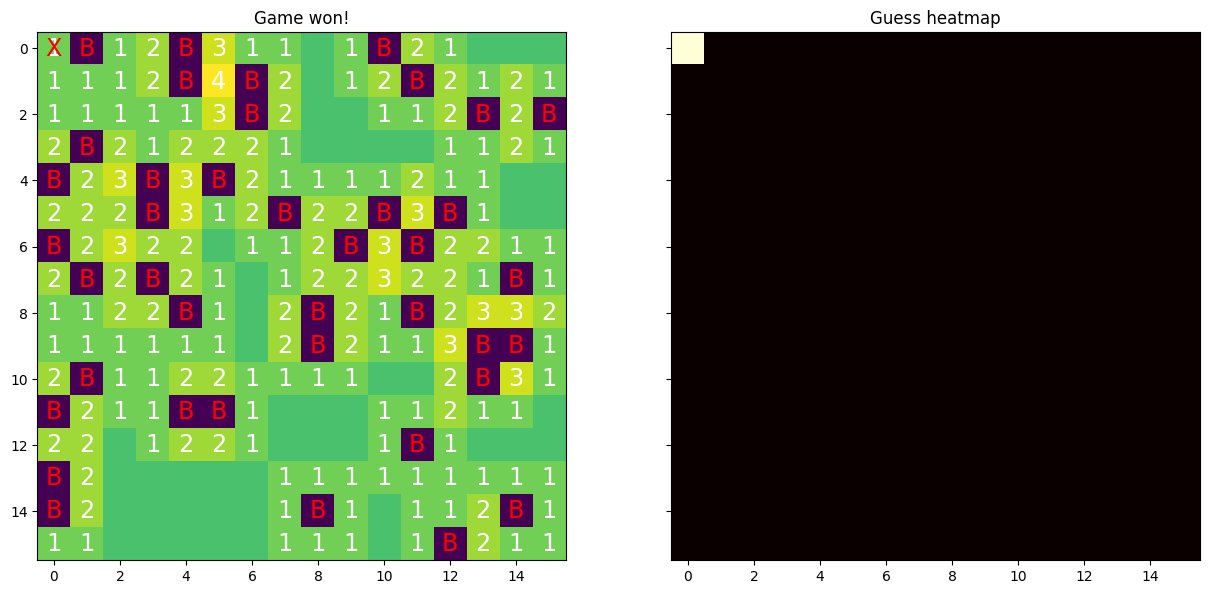

In [22]:
game = MinesweeperGame(width=16, height=16, mines=40)
run_game_with_visuals(pytorchsweeper_model, game, device)